# Image Classification with PyTorch and Cleanlab


Thi notebook demonstrates how to find potential label errors in image classification data. Here we use the MNIST dataset containing 70,000 images of handwritten digits from 0 to 9.

**Overview of what we'll do in this tutorial:**

- Build a simple [PyTorch](https://pytorch.org/) neural net and wrap it with [skorch](https://skorch.readthedocs.io/) to make it scikit-learn compatible.

- Use this model to compute out-of-sample predicted probabilities, `pred_probs`, via cross-validation.

- Compute a list of potential label errors with cleanlab's `find_label_issues` method.


## 1. Install the required dependencies


You can use `pip` to install all packages required for this tutorial as follows:


In [ ]:
!pip install matplotlib torch torchvision skorch
!pip install cleanlab

Check to see if required dependencies are installed

In [ ]:
# Package installation.
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "torchvision", "skorch"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab==v2.0.0
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

We set a seed for reproducibility.

In [ ]:
import numpy as np
import torch
import warnings

SEED = 321 #any constant value
np.random.seed(SEED)  #using the same seed for numpy and torch
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*") #ignore warning related to lazy modules

## 2. Fetch and scale the MNIST dataset


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")  # Fetch the MNIST dataset

X = mnist.data.astype("float32").to_numpy() # 2D array (images are flattened into 1D)
X /= 255.0  # Scale the features to the [0, 1] range

X = X.reshape(len(X), 1, 28, 28)  # reshape into [N, C, H, W] for PyTorch


y = mnist.target.astype("int64").to_numpy()  # 1D array of labels

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<div class="alert alert-info">If using different data:

Assign your data's features to variable `X` and its labels to variable `y` instead.

Your classes (and entries of `y`) should be represented as integer indices 0, 1, ..., num_classes - 1.

</div>


## 3. Define a classification model


Here, we define a simple neural network with PyTorch.
2 fully connected layers

In [ ]:
from torch import nn

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

## 4. Ensure your classifier is scikit-learn compatible


As some cleanlab features require scikit-learn compatibility, we adapt the above PyTorch neural net accordingly. [skorch](https://skorch.readthedocs.io) is a convenient package that helps with this. Alternatively, you can also easily wrap an arbitrary model to be scikit-learn compatible as demonstrated [here](https://github.com/cleanlab/cleanlab#use-cleanlab-with-any-model-tensorflow-pytorch-sklearn-xgboost-etc).

In [ ]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(ClassifierModule)

## 5. Compute out-of-sample predicted probabilities


If we'd like cleanlab to identify potential label errors in the whole dataset and not just the training set, we can consider using the entire dataset when computing the out-of-sample predicted probabilities, `pred_probs`, via cross-validation.


In [ ]:
from sklearn.model_selection import cross_val_predict

num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7882       0.9116        0.3209  6.7005
      2        0.2220       0.9371        0.2101  7.1840
      3        0.1577       0.9495        0.1663  6.4759
      4        0.1277       0.9581        0.1420  7.2459
      5        0.1093       0.9610        0.1265  6.8454
      6        0.0966       0.9636        0.1157  7.0835
      7        0.0872       0.9661        0.1075  7.3456
      8        0.0798       0.9691        0.1010  6.9067
      9        0.0737       0.9716        0.0957  7.6529
     10        0.0686       0.9716        0.0915  8.1404
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7167       0.9245        0.2801  7.5872
      2        0.2061       0.9480        0.1820  7.9981
      3        0.1450       0.9566        0.1470  7.8260
      4        0.1174       0.9

An additional benefit of cross-validation is that it facilitates more reliable evaluation of our model than a single training/validation split.

In [ ]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9748428571428571


## 6. Use cleanlab to find label issues


Based on the given labels and out-of-sample predicted probabilities, cleanlab can quickly help us identify label issues in our dataset. Here we request that the indices of the identified label issues be sorted by cleanlab's self-confidence score, which measures the quality of each given label via the probability assigned to it in our model's prediction.

In [ ]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    y,
    pred_probs,
    return_indices_ranked_by="self_confidence",
    frac_noise=1
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")

Cleanlab found 148 label issues.
Top 15 most likely label errors: 
 [59915 24798  8729 31134 19124 37427 27522 26471 53638  6848  2720 23824
  2676 20672  8200]


`ranked_label_issues` is a list of indices corresponding to examples that are worth inspecting more closely. To help visualize specific examples, we define a `plot_examples` function (can skip these details).

In [ ]:
import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"id: {id} \n label: {y[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

Let's look at the top 20 examples cleanlab thinks are most likely to be incorrectly labeled. We can see a few label errors and odd edge cases. Feel free to change the values below to display more/fewer examples.

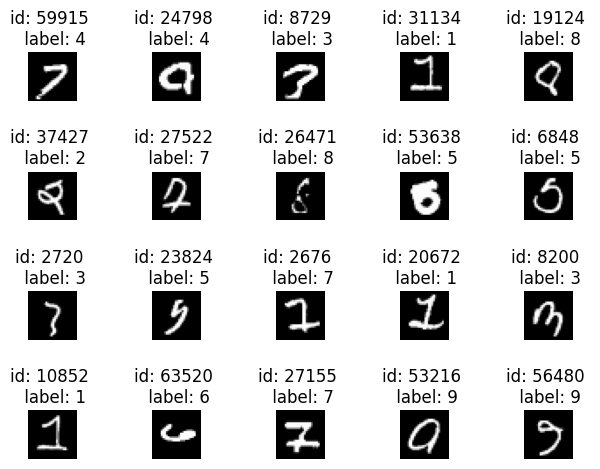

In [ ]:
plot_examples(ranked_label_issues[range(20)], 4, 5)

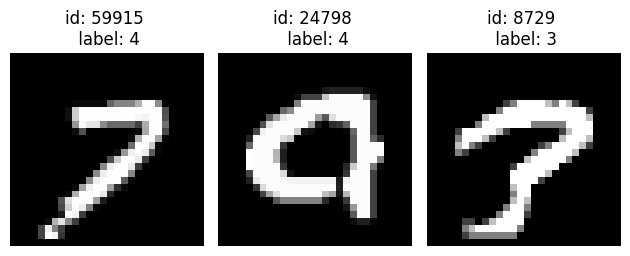

In [ ]:
BeforeRemoval = ranked_label_issues[range(3)]
plot_examples(BeforeRemoval[range(3)], 1, 3)

In [ ]:
# Assuming original_dataset is your original MNIST dataset array
# and mislabel_indices is the list of indices with mislabeled instances
  #original_dataset = X  # Your original dataset (70000 x num_features array)
  #mislabel_indices = [ranked_label_issues]  # List of indices with mislabeled instances

# Create a new dataset excluding mislabeled instances
  #clean_dataset = np.delete(original_dataset, mislabel_indices, axis=0)

# clean_dataset now contains the dataset without the mislabeled instances


## 7. Getting Data from the process


In [ ]:
cleanlab.count.estimate_joint(y, pred_probs)

NameError: name 'cleanlab' is not defined

In [ ]:
cleanlab.count.compute_confident_joint(y, pred_probs)

In [ ]:
testingThresholds = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

cleanlab.count.compute_confident_joint(y, pred_probs, thresholds=testingThresholds)

In [ ]:


(
    py, noise_matrix, inverse_noise_matrix, confident_joint
) = cleanlab.count.estimate_py_and_noise_matrices_from_probabilities(y, pred_probs)


# Get the joint distribution of noisy and true labels from the confident joint
# This is the most powerful statistic in machine learning with noisy labels.
joint = cleanlab.count.estimate_joint(
    y, pred_probs, confident_joint=confident_joint
)

# Pretty print the joint distribution and noise matrix
cleanlab.internal.util.print_joint_matrix(joint)
cleanlab.internal.util.print_noise_matrix(noise_matrix)

The Cell bellow is used for testing with a different model to get the predicted probabilities

In [ ]:
#provide X but only the first 2 dimensions (70000,1)

X0 = np.reshape(X, (70000, 28*28))  #reshape the dataset
X1 = X0[:70000, :]
y1 = y[:70000]  #reshape the labels to match the same format


import cleanlab
from sklearn.linear_model import LogisticRegression

linReg=LogisticRegression(max_iter=1000)#doesn't converge with standard max iteration, need to set high eg:1000

pred_probs2 = cleanlab.count.estimate_cv_predicted_probabilities(
    X1, y1, clf=linReg, seed=SEED
)

print(f"pred_probs is a {pred_probs2.shape} matrix of predicted probabilites")